In [1]:
from common import colors, insetlw

In [2]:
import os
os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/Users/eharkin/Documents/projects/5HTGIF


In [3]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns
from scipy import stats
from ezephys import pltools

from grr.ThresholdModel import constructMedianModel
from grr.Tools import dashedBorder

In [4]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'GIF_filters')

In [5]:
MODEL_PATH = os.path.join('data', 'models')

In [6]:
models = {}
for celltype in ['GABA', '5HT', 'mPFC']:
    models[celltype] = {}
    for modtype in ['GIFs', 'AugmentedGIFs', 'iGIF_NPs']:
        with open(os.path.join(MODEL_PATH, celltype, '_'.join([celltype, modtype]) + '.lmod'), 'rb') as f:
            models[celltype][modtype] = pickle.load(f)

In [7]:
median_models = {
    '5HT': constructMedianModel(type(models['5HT']['GIFs'][0]), models['5HT']['GIFs']),
    'GABA': constructMedianModel(type(models['GABA']['GIFs'][0]), models['GABA']['GIFs']),
    'mPFC': constructMedianModel(type(models['mPFC']['GIFs'][0]), models['mPFC']['GIFs'])
}

# Publication figures

In [9]:
xlims = (0.8, 700)
ylims = {
    'membrane': (-2, 35),
    'eta': (-0.205, 0.7)
}

# All cell types together

In [10]:
ax_props = {
    'xlim': (0.8, 700),
    'ylim': (-2, 35),
    'xticklocs': None,
    'yticklocs': (0, 10, 20, 30),
}

def filter_plot(filter_tupples, color_list=['k'], label_list=[None], axes_props=None, ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()

    color_list = color_list if len(color_list) == len(filter_tupples) else color_list * len(filter_tupples)
    label_list = label_list if len(label_list) == len(filter_tupples) else label_list * len(filter_tupples)
    for color, label, (t, filt) in zip(color_list, label_list, filter_tupples):
        ax.semilogx(t, filt, color=color, label=label, **pltargs)
    
    if axes_props is not None:
        if axes_props.get('xlim', None) is not None:
            ax.set_xlim(axes_props['xlim'])
        if axes_props.get('ylim', None) is not None:
            ax.set_ylim(axes_props['ylim'])
        if axes_props.get('xticklocs', None) is not None:
            ax.set_xticks(axes_props['xticklocs'])
        if axes_props.get('yticklocs', None) is not None:
            ax.set_yticks(axes_props['yticklocs'])

IOError: [Errno 13] Permission denied: 'figs/ims/writeup/GIF_filters/compound_filter_plot.png'

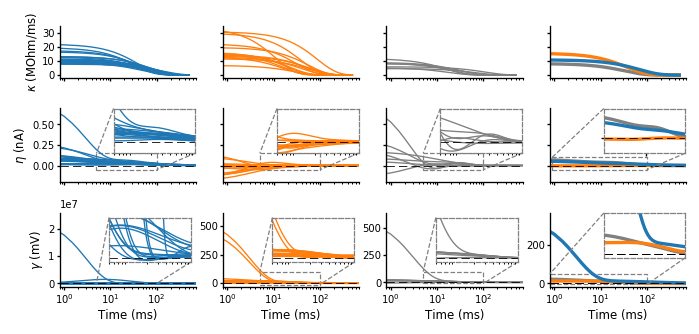

In [11]:
spec = gs.GridSpec(3, 4, height_ratios=[0.7, 1, 1], hspace=0.45, left=0.1, bottom=0.1, right=0.97, top=0.97)

plt.figure(figsize=(6, 2.5))

## Top row: Membrane filters
membrane_filt_ax_props = {
    'xlim': xlims,
    'ylim': (-2, 35),
    'yticklocs': (0, 10, 20, 30)
}
for i, (data_name, color_name) in enumerate(zip(['5HT', 'GABA', 'mPFC'], ['ser', 'som', 'pyr'])):
    plt.subplot(spec[0, i])
    filter_plot(
        [mod.getInterpolatedMembraneFilter(500, 0.5) for mod in models[data_name]['GIFs']],
        [colors[color_name]],
        axes_props = membrane_filt_ax_props
    )
    
    if i == 0:
        plt.ylabel(r'$\kappa$ (MOhm/ms)')
    else:
        plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    pltools.hide_border('tr')


## Middle row: spike-triggered current (eta)
eta_ax_props = {
    'xlim': xlims,
    'ylim': (-0.205, 0.7),
    'yticklocs': (0, 0.25, 0.5)
}
for i, (data_name, color_name) in enumerate(zip(['5HT', 'GABA', 'mPFC'], ['ser', 'som', 'pyr'])):
    tmp_eta_ax = plt.subplot(spec[1, i])
    tmp_eta_inset = inset_axes(tmp_eta_ax, '60%', '60%', loc='upper right', borderpad=0.05)
    for tmp_ax in (tmp_eta_ax, tmp_eta_inset):
        filter_plot(
            [mod.eta.getInterpolatedFilter(0.5) for mod in models[data_name]['GIFs']],
            [colors[color_name]],
            axes_props=eta_ax_props,
            ax=tmp_ax
        )
        tmp_ax.axhline(0, lw=0.5, ls='--', color='k', dashes=(10, 5))
    
    tmp_eta_inset.set_xlim(5, 100)
    tmp_eta_inset.set_ylim(-0.05, 0.15)
    mark_inset(tmp_eta_ax, tmp_eta_inset, 2, 4, ls='--', color='gray', lw=insetlw)
    dashedBorder(tmp_eta_inset, lw=insetlw)
    pltools.hide_ticks(ax=tmp_eta_inset)
    
    if i == 0:
        tmp_eta_ax.set_ylabel('$\eta$ (nA)')
    else:
        tmp_eta_ax.set_yticklabels([])
    tmp_eta_ax.set_xticklabels([])
    pltools.hide_border('tr', ax=tmp_eta_ax)
    

## Bottom row: spike-triggered threshold movement (gamma)
gamma_ax_props = {
    'xlim': xlims,
}
gamma_ylims = [(-10, 100), (-10, 100), (-10, 100)]
for i, (data_name, color_name) in enumerate(zip(['5HT', 'GABA', 'mPFC'], ['ser', 'som', 'pyr'])):
    tmp_gamma_ax = plt.subplot(spec[2, i])
    tmp_gamma_inset = inset_axes(tmp_gamma_ax, '60%', '60%', loc='upper right', borderpad=0.5)
    for tmp_ax in (tmp_gamma_ax, tmp_gamma_inset):
        filter_plot(
            [mod.gamma.getInterpolatedFilter(0.5) for mod in models[data_name]['GIFs']],
            [colors[color_name]],
            axes_props=gamma_ax_props,
            ax=tmp_ax
        )
        tmp_ax.axhline(0, lw=0.5, ls='--', color='k', dashes=(10, 5))
    
    tmp_gamma_inset.set_xlim(5, 100)
    tmp_gamma_inset.set_ylim(gamma_ylims[i])
    mark_inset(tmp_gamma_ax, tmp_gamma_inset, 2, 4, ls='--', color='gray', lw=insetlw)
    dashedBorder(tmp_gamma_inset, lw=insetlw)
    pltools.hide_ticks(ax=tmp_gamma_inset)
    
    if i == 0:
        tmp_gamma_ax.set_ylabel('$\gamma$ (mV)')
    tmp_gamma_ax.set_xlabel('Time (ms)')
    pltools.hide_border('tr', ax=tmp_gamma_ax)

    
## Rightmost column: median filters
plt.subplot(spec[0, 3])
for mod_name, color_name in zip(['mPFC', 'GABA', '5HT'], ['pyr', 'som', 'ser']):
    t, filt = median_models[mod_name].getInterpolatedMembraneFilter(500., 0.5)
    plt.semilogx(t, filt, lw=2, color=colors[color_name], label=mod_name)
    
plt.xlim(xlims)
plt.gca().set_xticklabels([])
plt.yticks([0, 10, 20, 30])
plt.gca().set_yticklabels([])
plt.ylim(ylims['membrane'])
pltools.hide_border('tr')

median_eta_ax = plt.subplot(spec[1, 3])
median_eta_inset = inset_axes(median_eta_ax, '60%', '60%', loc='upper right', borderpad=0.05)
for tmp_ax in (median_eta_ax, median_eta_inset):
    filter_plot(
        [median_models[mod_name].eta.getInterpolatedFilter(0.5) for mod_name in ['mPFC', 'GABA', '5HT']],
        [colors[color_name] for color_name in ['pyr', 'som', 'ser']],
        label_list=['mPFC', 'GABA', '5HT'],
        lw=2,
        axes_props=eta_ax_props,
        ax=tmp_ax
    )
    tmp_ax.axhline(0, lw=0.5, ls='--', color='k', dashes=(10, 5))
    
    tmp_ax.set_xticklabels([])
    tmp_ax.set_yticklabels([])

median_eta_inset.set_xlim(0.9, 100)
median_eta_inset.set_ylim(-0.05, 0.1)
mark_inset(median_eta_ax, median_eta_inset, 2, 4, ls='--', color='gray', lw=insetlw)
dashedBorder(median_eta_inset, lw=insetlw)
pltools.hide_border('tr', ax=median_eta_ax)


gamma_allcells_ax = plt.subplot(spec[2, 3])
gamma_allcells_inset = inset_axes(
    gamma_allcells_ax, '60%', '60%', loc='upper right', borderpad=0.05,
)
for mod_name, color_name in zip(['mPFC', 'GABA', '5HT'], ['pyr', 'som', 'ser']):
    t, filt = median_models[mod_name].gamma.getInterpolatedFilter(0.5)
    gamma_allcells_ax.semilogx(t, filt, lw=2, color=colors[color_name], label=mod_name)
    gamma_allcells_inset.semilogx(t, filt, lw=2, color=colors[color_name], label=mod_name)
    gamma_allcells_ax.axhline(0, lw=0.5, ls='--', color='k', dashes=(10, 5))
    gamma_allcells_inset.axhline(0, lw=0.5, ls='--', color='k', dashes=(10, 5))
    
gamma_allcells_ax.set_xlim(xlims)
gamma_allcells_ax.set_xlabel('Time (ms)')

gamma_allcells_inset.set_xlim(0.8, 100)
gamma_allcells_inset.set_ylim(-5, 50)
mark_inset(
    gamma_allcells_ax,
    gamma_allcells_inset,
    2,
    4,
    ls='--',
    color='gray',
    lw=insetlw,
)
dashedBorder(gamma_allcells_inset, lw=insetlw)
pltools.hide_ticks(ax=gamma_allcells_inset)

pltools.hide_border('tr', ax=gamma_allcells_ax)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'compound_filter_plot.png'))
    plt.savefig(os.path.join(IMG_PATH, 'compound_filter_plot.svg'))

In [12]:
def nonparametric_filter_plot(time_supp, interpolated_filters, quantiles=(25, 75), ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()
        
    zorder = pltargs.pop('zorder', 0)

    median = np.percentile(interpolated_filters, 50, axis=0)
    lower_quantile = np.percentile(interpolated_filters, quantiles[0], axis=0)
    upper_quantile = np.percentile(interpolated_filters, quantiles[1], axis=0)

    ax.fill_between(
        time_supp, 
        lower_quantile, 
        upper_quantile, 
        edgecolor='none', 
        facecolor=pltargs.get('color', 'gray'), 
        alpha=0.5,
        zorder=zorder
    )
    ax.plot(time_supp, median, zorder=zorder+1, **pltargs)

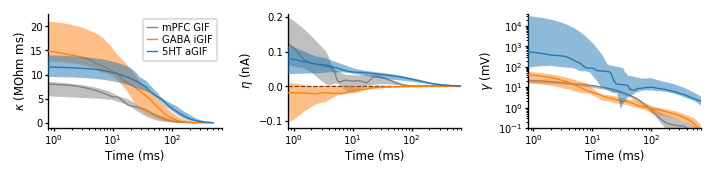

In [48]:
plt.figure(figsize=(6, 1.5))

plt.subplot(131)
for i, (data_name, color_name, model_name, model_type) in enumerate(
    zip(
        ['mPFC', 'GABA', '5HT'], 
        ['pyr', 'som', 'ser'],
        ['GIF', 'iGIF', 'aGIF'],
        ['GIFs', 'iGIF_NPs', 'AugmentedGIFs']
    )
):
    membrane_filters = [
        mod.getInterpolatedMembraneFilter(500, 0.5)
        for mod in models[data_name][model_type]
    ]
    membrane_filter_array = np.array(membrane_filters)[:, 1, :]
    membrane_time_supp = membrane_filters[0][0]

    nonparametric_filter_plot(
        membrane_time_supp,
        membrane_filter_array,
        color=colors[color_name],
        zorder=i * 2,
        label=' '.join([data_name, model_name]),
    )
    
plt.gca().set_xscale('log')
plt.xlim(xlims)
plt.xlabel('Time (ms)')
plt.ylabel(r'$\kappa$ (MOhm ms)')
pltools.hide_border('tr')
plt.legend()

plt.subplot(132)
plt.axhline(0, color='k', ls='--', dashes=(10, 10), lw=0.7, zorder=-1)
for i, (data_name, color_name, model_name, model_type) in enumerate(
    zip(
        ['mPFC', 'GABA', '5HT'], 
        ['pyr', 'som', 'ser'],
        ['GIF', 'iGIF', 'aGIF'],
        ['GIFs', 'iGIF_NPs', 'AugmentedGIFs']
    )
):
    eta_filters = [
        mod.eta.getInterpolatedFilter(0.5) for mod in models[data_name][model_type]
    ]
    eta_filter_array = np.array(eta_filters)[:, 1, :]
    eta_time_supp = eta_filters[0][0]

    nonparametric_filter_plot(
        eta_time_supp,
        eta_filter_array,
        color=colors[color_name],
        zorder=i * 2,
        label=' '.join([data_name, model_name]),
    )
    
plt.gca().set_xscale('log')
plt.xlim(xlims)
plt.ylim(-0.12, 0.21)
plt.xlabel('Time (ms)')
plt.ylabel(r'$\eta$ (nA)')
pltools.hide_border('tr')

gamma_ax = plt.subplot(133)
for i, (data_name, color_name, model_name, model_type) in enumerate(
    zip(
        ['mPFC', 'GABA', '5HT'], 
        ['pyr', 'som', 'ser'],
        ['GIF', 'iGIF', 'aGIF'],
        ['GIFs', 'iGIF_NPs', 'AugmentedGIFs']
    )
):
    gamma_filters = [
        mod.gamma.getInterpolatedFilter(0.5)
        for mod in models[data_name][model_type]
    ]
    gamma_filter_array = np.array(gamma_filters)[:, 1, :]
    gamma_time_supp = gamma_filters[0][0]

    nonparametric_filter_plot(
        gamma_time_supp,
        gamma_filter_array,
        color=colors[color_name],
        zorder=i * 2,
        ax=gamma_ax,
        label=' '.join([data_name, model_name]),
    )

gamma_ax.set_xscale('log')
gamma_ax.set_yscale('log')
gamma_ax.set_xlim(xlims)
gamma_ax.set_ylim(0.1, 4e4)


pltools.hide_border('tr', ax=gamma_ax)
pltools.hide_border('tr', ax=gamma_inset)

gamma_ax.set_xlabel('Time (ms)')
gamma_ax.set_ylabel(r'$\gamma$ (mV)')

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'nonparametric_filter_plot.png'))
    plt.savefig(os.path.join(IMG_PATH, 'nonparametric_filter_plot.svg'))

# Statistics on filters

In [24]:
gamma_filters = [
        mod.gamma.getInterpolatedFilter(0.5)
        for mod in models['5HT']['AugmentedGIFs']
    ]

In [25]:
def get_adaptation_filters_and_support(models):
    output = {}
    for filter_type in ['eta', 'gamma']:
        filters = [
            getattr(mod, filter_type).getInterpolatedFilter(0.5)
            for mod in models
        ]
        filter_array = np.array(filters)[:, 1, :]
        time_supp = filters[0][0]
        output[filter_type] = {
            'filter': filter_array,
            'time': time_supp
        }
    return output

In [26]:
filters = {
    'ser': get_adaptation_filters_and_support(models['5HT']['AugmentedGIFs']),
    'som': get_adaptation_filters_and_support(models['GABA']['iGIF_NPs']),
    'pyr': get_adaptation_filters_and_support(models['mPFC']['GIFs'])
}

In [27]:
result = stats.mannwhitneyu(
    filters['ser']['eta']['filter'][:, 600],
    filters['som']['eta']['filter'][:, 600],
    alternative='two-sided'
)
print(result.pvalue * 3)

6.840252864740476e-05


In [28]:
result = stats.mannwhitneyu(
    filters['ser']['eta']['filter'][:, 600],
    filters['pyr']['eta']['filter'][:, 600],
    alternative='two-sided'
)
print(result.pvalue * 3)

0.009995035717775203


In [29]:
result = stats.mannwhitneyu(
    filters['som']['eta']['filter'][:, 600],
    filters['pyr']['eta']['filter'][:, 600],
    alternative='two-sided'
)
print(result.pvalue * 3)

0.43718069452629493


In [30]:
filters['ser']['eta']['time'][600]

300.0

In [31]:
for cell_type in ['ser', 'pyr', 'som']:
    print('{}: {:.6f} +/- {:.6f}, median {:.6f}'.format(
        cell_type,
        np.mean(filters[cell_type]['eta']['filter'][:, 600]),
        np.std(filters[cell_type]['eta']['filter'][:, 600]),
        np.median(filters[cell_type]['eta']['filter'][:, 600])
    ))

ser: 0.005890 +/- 0.003310, median 0.005070
pyr: 0.001186 +/- 0.001958, median 0.001366
som: 0.000645 +/- 0.001296, median 0.000482


In [32]:
stats.mannwhitneyu(
    filters['ser']['gamma']['filter'][:, 600],
    filters['som']['gamma']['filter'][:, 600],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=250.0, pvalue=2.7137231242905924e-06)

In [33]:
stats.mannwhitneyu(
    filters['ser']['gamma']['filter'][:, 600],
    filters['pyr']['gamma']['filter'][:, 600],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=126.0, pvalue=0.00015515375990895068)

In [34]:
filters['ser']['gamma']['time'][600]

300.0

In [35]:
for cell_type in ['ser', 'pyr', 'som']:
    print('{}: {:.6f} +/- {:.6f}, median {:.6f}'.format(
        cell_type,
        np.mean(filters[cell_type]['gamma']['filter'][:, 600]),
        np.std(filters[cell_type]['gamma']['filter'][:, 600]),
        np.median(filters[cell_type]['gamma']['filter'][:, 600])
    ))

ser: 13.120793 +/- 25.398816, median 4.964471
pyr: 0.172452 +/- 0.163249, median 0.126938
som: 0.548819 +/- 0.525902, median 0.398373


# Nicer plot of gamma filter

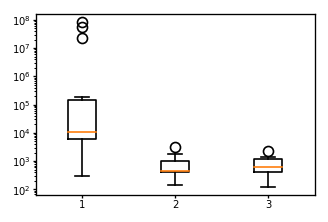

In [47]:
dt = 0.5
plt.boxplot([
    filters['ser']['gamma']['filter'].sum(axis=1) * dt, 
    filters['som']['gamma']['filter'].sum(axis=1) * dt,
    filters['pyr']['gamma']['filter'].sum(axis=1) * dt
])
plt.yscale('log')

In [45]:
filters['som']['gamma']['filter'].sum(axis=1) * dt

array([1143.56153612,  572.5329117 ,  457.77452041,  450.64643158,
        435.75826151,  137.91009949,  317.02014727,  395.27644964,
        270.26388546, 1464.2549438 ,  550.03409982, 3048.79257666,
        419.4332019 , 1752.06160149])

In [46]:
filters['pyr']['gamma']['filter'].sum(axis=1) * dt

array([2343.92739706,  610.8022718 ,  124.27211287, 1446.11871377,
        359.24111645,  893.06921556,  500.51477   ])

In [39]:
filters['ser']['gamma']['time'][-1] - filters['ser']['gamma']['time'][-1]

array([0.00000e+00, 5.00000e-01, 1.00000e+00, ..., 2.99985e+04,
       2.99990e+04, 2.99995e+04])